#### In this notebook, all the punctuations are not removed. Single "?" and "!" are kept.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from autocorrect import Speller
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

## Import the Data

In [2]:
df = pd.read_csv('Scrapper/final.csv', header=None)
# df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
# Printing unique category
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'other', 'correction',
       'negative'], dtype=object)

In [4]:
# Checking null values
df.isnull().sum()

0    0
1    0
dtype: int64

In [5]:
# Checking the shape of the data
df.shape

(1254, 2)

## Preprocessing

In [6]:
# Preprocessing

# lowercasing
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].replace('\n','', regex=True)

# # removing all the punctuations
# df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df

,0,1
0,love you sir,positive
1,please make videos on..midpoint circle drawing...,imperative
2,i bought both of your courses on udemy. you ar...,interrogative
3,"thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,other
...,...,...
1249,sir could you please post all the videos on c,interrogative
1250,"sir ,after in part u discussed about file ex...",interrogative
1251,sir please post more videos on functions and p...,imperative
1252,please post operator concept videos like post ...,imperative


In [7]:
# removing punctuations except ! and ?
import string

def remove_punctuations(text):
    
    punct = string.punctuation
    punct = punct.replace('!', '')
    punct = punct.replace('?', '')
    
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

df[0] = df[0].apply(remove_punctuations)

# replacing sequence of "!" with single "!"
def replace(string, char): 
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string 

char = '!'

df_ = pd.DataFrame(columns=['comment', 'category'])

for index, row in df.iterrows():
    df_ = df_.append({'comment':replace(row[0], char), 'category':row[1]}, ignore_index=True)

# replacing sequence of "?" with single "?"
def replace_q(string):
    char = '?'
    string = re.sub('[?-?]+', char, string)
    return string

df_['comment'] = df_['comment'].apply(replace_q)
df_

,comment,category
0,love you sir,positive
1,please make videos onmidpoint circle drawing a...,imperative
2,i bought both of your courses on udemy you are...,interrogative
3,thank you very much u really got me in the fir...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1249,sir could you please post all the videos on c,interrogative
1250,sir after in part u discussed about file ext...,interrogative
1251,sir please post more videos on functions and p...,imperative
1252,please post operator concept videos like post ...,imperative


In [8]:
df_.rename(columns={'comment':0, 'category':1}, inplace=True)
df_

,0,1
0,love you sir,positive
1,please make videos onmidpoint circle drawing a...,imperative
2,i bought both of your courses on udemy you are...,interrogative
3,thank you very much u really got me in the fir...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1249,sir could you please post all the videos on c,interrogative
1250,sir after in part u discussed about file ext...,interrogative
1251,sir please post more videos on functions and p...,imperative
1252,please post operator concept videos like post ...,imperative


In [9]:
# correcting the typos

spell = Speller(lang='en')

def typo_corrector(text):
    return spell(text)

df_[0] = df_[0].apply(typo_corrector)
df_[0]

0            positive
1          imperative
2       interrogative
3            positive
4               other
            ...      
1249    interrogative
1250    interrogative
1251       imperative
1252       imperative
1253         positive
Name: 1, Length: 1254, dtype: object

In [10]:
# stemming
stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df_[0] = df_[0].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df_[0] = df_[0].apply(lemmatize_text)
df_

,0,1
0,love you sir,positive
1,please make videos midpoint circle drawing and...,imperative
2,i bought both of your courses on demy you are ...,interrogative
3,thank you very much u really got me in the fir...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1249,sir could you please post all the videos on c,interrogative
1250,sir after in part u discussed about file ext...,interrogative
1251,sir please post more videos on functions and p...,imperative
1252,please post operator concept videos like post ...,imperative


In [11]:
# Removing stopwords
stop = stopwords.words('english')

df_[0] = df_[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_


,0,1
0,love sir,positive
1,please make videos midpoint circle drawing bre...,imperative
2,bought courses demy talented teacher keep prod...,interrogative
3,thank much u really got first video algorithm ...,positive
4,hope u ok everything going muslims idea,other
...,...,...
1249,sir could please post videos c,interrogative
1250,sir part u discussed file extensions cis platf...,interrogative
1251,sir please post videos functions pointers stru...,imperative
1252,please post operator concept videos like post ...,imperative


## Feature Extaction


In [12]:
# Feature Extraction

N_occurance = 5


words = [df_[0][i].split() for i in range(len(df_))]
bag_of_words = sorted(list({word for list_ in words for word in list_}))
word_count = {word:0 for word in bag_of_words}
for word in bag_of_words:
    for list_ in words:
        if word in list_:
            word_count[word]+=1
filtered_words = [k for k,v in word_count.items() if v>N_occurance]
evaluation = np.zeros((len(df_),len(filtered_words)))
for i in range(len(words)):
    counter = Counter(words[i])
    for k, v in counter.items():
        if k not in filtered_words:
            continue
        count = [1 for list_ in words if k in list_]
        evaluation[i][filtered_words.index(k)] = v*sum(count)/len(words[i])

# print(filtered_words)
evaluation.shape

(1254, 289)

In [13]:
features = evaluation
features.shape

(1254, 289)

## Applying models and calculating the scores

/Volumes/MyFiles/Projects/Youtube-Comments-Categorization/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Volumes/MyFiles/Projects/Youtube-Comments-Categorization/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Volumes/MyFiles/Projects/Youtube-Comments-Categorization/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Volumes/MyFiles/Projects/Youtube-Comments-Categorization/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Converge

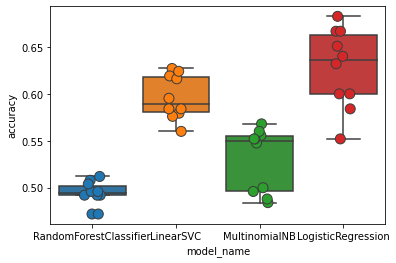

In [14]:
# Applying models


labels = df_[1]
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [15]:
# Printing the accuracies

cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.596463
LogisticRegression        0.627467
MultinomialNB             0.530330
RandomForestClassifier    0.493613
Name: accuracy, dtype: float64

## Appyling other models

In [16]:
X = features
y = df_.iloc[:, 1].values

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.5856573705179283


In [19]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6454183266932271


In [20]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6653386454183267


/Volumes/MyFiles/Projects/Youtube-Comments-Categorization/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.5179282868525896


In [22]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.5976095617529881


In [23]:
# Kernal SVC RBF

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.549800796812749


In [24]:
# Kernal SVC sigmoid

classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.4581673306772908


In [25]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6693227091633466


In [26]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6095617529880478
